# Behavioral Data Analysis

This notebook generates timecourse analyses and figures for experiments 1 and 2.

### Imports

In [2]:
import pandas as pd; import seaborn as sb; import warnings; import pingouin; import scipy; import re; import os
import pingouin; from analysis_helpers import *
import random
warnings.filterwarnings('ignore')
%matplotlib inline

### Load Data

In [3]:
exp1 = pd.DataFrame.from_csv('/Users/kirstenziman/Desktop/new_place/attention-memory-task/Experiment1_BlockCue/code/parsed_data/behavioral_data_exp1.csv')
exp2 = pd.DataFrame.from_csv('/Users/kirstenziman/Desktop/new_place/attention-memory-task/Experiment2_TrialCue/code/analysis/behavioral.csv')

### Make sure all images labeled by their inherent category (use image filename)

In [4]:
exp2.ix[ exp2['Memory Image'].str.contains("sun", na=False),'Category']='Place'
exp2.ix[~exp2['Memory Image'].str.contains("sun", na=False),'Category']='Face'
exp2.loc[exp2['Trial Type']=='Presentation','Category']=np.nan

### Make sure all memory trials are numbered

In [5]:
exp1.loc[exp1['Trial Type']=='Memory','Trial'] = list(range(0,40))*30*8
exp2.loc[exp2['Trial Type']=='Memory','Trial'] = list(range(0,40))*30*8

# Functions

In [6]:
def apply_window(combo, window_length):
    '''
    input:  dataframe of behavioral data from an entire experiment
    output: dataframe of same shape where raw values have been replaced by rolling window mean  
            WARNING: THE FIRST WINDOW_LENGTH-1 CELLS IN OUTPUTTED DF FROM ROLLING ARE PADDED / GIVE FUNNY RESULT?
    '''
    
    # select data from memory runs
    data = combo[combo['Trial Type']=='Memory'][['Attention Level','Familiarity Rating','Trial','Subject','Run']] 

    # re strucutre data - each row is a trial, each col is an attn level
    df = data.pivot_table(index=['Subject','Run','Trial'], 
                          columns='Attention Level', 
                         values='Familiarity Rating')

    # apply rolling window, for each run in each subject
    window_data = df.groupby(['Subject','Run']).apply(lambda x: x.rolling(window_length, min_periods=1, center = True).mean())

    return(window_data)

In [7]:
def add_nov_label(combo, column_name='Cued Category'):
    '''
    input:  dataframe of participant data, and the name of the column to use for cue info
            for exp1 use 'Cued Category' (cue for that block)
            for exp2 use 'Last Cued'     (last cue from presentation block)
    output: dataframe where novel images are labeled by cued or uncued category
    '''

    combo.loc[combo['Attention Level']=='Novel','Attention Level'] = 'Nov_Un'
    
    for snuffle in ['Face','Place']:

        # for all 'Novel', if image in cued category, rename 'Novel_Cued'
        combo.loc[(combo['Trial Type']=='Memory') & (combo[column_name]==snuffle) & (combo['Category']==snuffle) 
                  & (combo['Attention Level'].isin(['Nov_Un','Novel','Nov_Cued'])),
                     'Attention Level'] = 'Nov_Cued'
        
        combo.loc[(combo['Trial Type']=='Memory') 
                  & (combo[column_name]!=snuffle) 
                  & (combo['Category']==snuffle)
                  & (combo['Attention Level'].isin(['Novel','Nov_Un','Nov_Cued'])),
                     'Attention Level'] = 'Nov_Un'
    return(combo)

# Organize Data

### Exp2: add column for the last-cued category before each memory block

In [8]:
exp2['Last Cued'] = np.nan

for sub in exp2['Subject'].unique():
    for run in exp2['Run'].unique():
        
        # obtain cued category from the last presentation trial
        last_cat = exp2[(exp2['Trial Type']=='Presentation')
                       & (exp2['Subject']==sub)
                       & (exp2['Run']==run)
                       & (exp2['Trial']==9)]['Cued Category'].item()
        # print(last_cat)
        
        # assign to this memory run
        exp2.loc[(exp2['Trial Type']=='Memory')
                       & (exp2['Subject']==sub)
                       & (exp2['Run']==run),'Last Cued'] = last_cat

In [9]:
# exp2.groupby(['Last Cued']).count()
# exp2.groupby(['Last Cued']).count()

#exp2[exp2['Subject']==5][['Category','Last Cued','Attention Level']]

### Re-Label Novel Images by Cued or Uncued category

In [10]:
exp1 = add_nov_label(exp1)
exp2 = add_nov_label(exp2, column_name ='Last Cued')

In [11]:
# exp2[['Last Cued','Category','Attention Level']]

In [12]:
# mem=exp2[(exp2['Trial Type']=='Memory']

# exp2['Attention Level'].where((exp2['Category']==exp2['Last Cued'])
#                               & (exp2['Attention Level'].isin(['Novel','Nov_Cued','Nov_Un'])
#                             & (exp2['Trial Type']=='Memory'))
#                               , 'Nov_Cued')

# exp2['Attention Level'].where((exp2['Category']!=exp2['Last Cued'])
#                               & (exp2['Attention Level'].isin(['Novel','Nov_Cued','Nov_Un'])
#                             & (exp2['Trial Type']=='Memory'))
#                               , 'Nov_Un')

In [13]:
exp2['Attention Level'].unique()

array([nan, 'Side', 'None', 'Nov_Cued', 'Category', 'Nov_Un', 'Full'],
      dtype=object)

# Plot Data

### Apply Sliding Window

In [14]:
window_length = 20

In [15]:
exp1_mean_window = apply_window(exp1, window_length)
exp2_mean_window = apply_window(exp2, window_length)

### Prepare data for plotting

In [16]:
plot_data={}

for data,key in zip([exp1_mean_window, exp2_mean_window],['exp1','exp2']):
    
    # average across all trials within each subject
    group = data.reset_index().groupby(['Subject','Trial']).mean()
    
    # melt/restructure the data
    group_melt = pd.melt(group.reset_index(), id_vars=['Subject','Trial'], 
                           value_vars=['Category', 'Full','None','Nov_Cued','Nov_Un','Side'])
    
    # remove extra cells at the beginning (pandas maintains same # of rows even after rolling window; weird values in first cells)
    # group_melt = group_melt[group_melt['Trial'].isin(range(window_length-1,40))]
    
    # assign data to dictionary key
    plot_data[key] = group_melt

# Plot Data !

### Mean Familiarity By Attention Level

Cued category    -->  warm colors <br/>
Uncued category  -->  cool colors

In [17]:
palette = sb.color_palette("RdBu", 20)

In [18]:
# exp2[['Attention Level','Category']]
# exp2['Attention Level'].unique()

## FIRST AND LAST TRIAL CHUNKS

Experiment_1_last_10: Average Familiarity by Attention Level


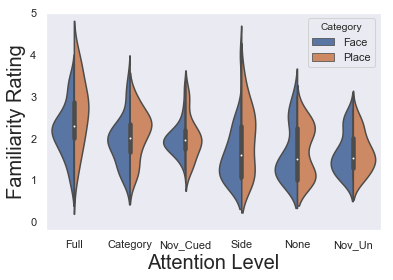

            Source  ddof1  ddof2       F         p-unc     p-GG-corr    np2  \
0  Attention Level      5    145  26.459  6.183781e-19  3.497119e-14  0.477   

     eps  sphericity  W-spher   p-spher  
0  0.715       False    0.297  0.002951  

Category vs. None
Ttest_relResult(statistic=4.3159385231916625, pvalue=0.00016865795388257407)

Category vs. Side
Ttest_relResult(statistic=2.5294318059480494, pvalue=0.017117429881773064)

Category vs. Full
Ttest_relResult(statistic=-3.8118737675189687, pvalue=0.0006651136114394587)

Category vs. Nov_Cued
Ttest_relResult(statistic=0.2997408507994759, pvalue=0.7665127876906009)

Category vs. Nov_Un
Ttest_relResult(statistic=4.941659146824058, pvalue=2.983199780416051e-05)

None vs. Side
Ttest_relResult(statistic=-1.6377514300678169, pvalue=0.11228043910654723)

None vs. Full
Ttest_relResult(statistic=-6.554770430897229, pvalue=3.519597287374258e-07)

None vs. Nov_Cued
Ttest_relResult(statistic=-4.1701630902089, pvalue=0.0002515780163902133)

None

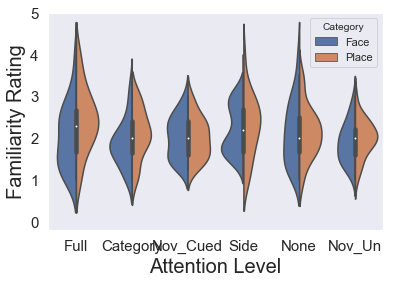

            Source  ddof1  ddof2      F    p-unc  p-GG-corr   np2   eps  \
0  Attention Level      5    145  5.132  0.00023   0.000915  0.15  0.77   

   sphericity  W-spher   p-spher  
0       False    0.401  0.036628  

Category vs. None
Ttest_relResult(statistic=-1.389505930631939, pvalue=0.1752557930415735)

Category vs. Side
Ttest_relResult(statistic=-2.904176080797565, pvalue=0.006974233214735291)

Category vs. Full
Ttest_relResult(statistic=-3.1397681399672024, pvalue=0.003868424452066323)

Category vs. Nov_Cued
Ttest_relResult(statistic=-0.38479429035962026, pvalue=0.703197449309425)

Category vs. Nov_Un
Ttest_relResult(statistic=0.6313496628444744, pvalue=0.5327571676563312)

None vs. Side
Ttest_relResult(statistic=-1.1997999889861375, pvalue=0.23992761686748512)

None vs. Full
Ttest_relResult(statistic=-1.4467921546624565, pvalue=0.1586785836696402)

None vs. Nov_Cued
Ttest_relResult(statistic=1.1984551725076802, pvalue=0.24044238080558006)

None vs. Nov_Un
Ttest_relResult(st

In [19]:
import itertools
from scipy import stats

for d,label in zip([exp1, exp2],['Experiment_1_last_10', 'Experiment_2_last_10']):
    
    d = d[d['Trial']>29]
    #d = d[d['Trial']<10]
    data = d.groupby(['Subject','Attention Level','Category'], as_index = False).mean()
    
    print(label + ': Average Familiarity by Attention Level')
    
    plt.grid(False)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Attention Level',    fontsize = 20)
    plt.ylabel('Familiarity Rating', fontsize = 20)
    
    sb_plot = sb.violinplot(x='Attention Level', y='Familiarity Rating', 
                 data = data,
                 order=['Full','Category','Nov_Cued','Side','None','Nov_Un'],
                           hue='Category', split=True)
#                  palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
#                             "Side": palette[19], "None": palette[16], "Nov_Un":palette[13]})
        
    save_string = label + '_violin_full.pdf'
    
    sb_plot.set(ylim=(-.2, 5))
    
    plt.savefig(save_string)
    plt.show()


    print(pingouin.rm_anova(dv='Familiarity Rating', within=['Attention Level'], subject='Subject', 
                  data=d.groupby(['Subject','Attention Level'],as_index=False).mean()))
    print()
    
    l=['Category','None','Side','Full','Nov_Cued','Nov_Un']
    k=data.groupby(['Subject','Attention Level'],as_index=False).mean()

    for pair in list(itertools.combinations(l, r=2)):
        t = stats.ttest_rel(k[k['Attention Level']==pair[0]]['Familiarity Rating'], 
                            k[k['Attention Level']==pair[1]]['Familiarity Rating'])

        # if t[1]>.05:
        print(pair[0]+" vs. "+pair[1])
        print(t) 
        print()



In [20]:
k = data.groupby(['Subject','Attention Level'],as_index=False).mean()

In [21]:
print(len(exp1['Subject'].unique()))
print(len(exp2['Subject'].unique()))

30
30


In [22]:
# ROC_input = exp1[exp1['Category']=='Face']
# ROC_input.loc[ROC_input['Attention Level']=='Nov_Un']='Novel'
# ROC_plot(ROC_data(ROC_input), novel='matched')

# Violins -- Full Data 

In [23]:
# def find_sig(stat_dict, cat_keys, n=1):
#     '''
#     find the nth rightward significant relationsip for this category
#     return iteration #
#     '''
    
#     t_sign = -1
#     iteration = 0
#     # make negative ttest sign and start iteration 0
    
#     all_positives = [x for x in cat_key]
    
#     if n ==1:

#         while t_sign<0 and iteration<len(cat_keys):
#             # loop until first positive relationship from left to right, for this category
#             t_sign = stat_dict[cat_keys[iteration]]['t']
#             ttest  = stat_dict[cat_keys[iteration]]
#             iteration += 1

#         iteration = iteration -1
        
#     else:
        
        
        

In [24]:
def sig_bars_neg(cat, cats, stat_dict, adjust=0):
    '''
    input:  left-most category, ordered category list, dictionary of significant ttests
    output: parameters for first significance line in descending cascade
    '''
    
    answer = []
    
    colors = ['r','m','c','y','g','b']
        
    cat_keys = [x for x in stat_dict.keys() if cat==x[0] and stat_dict[x]['t']<0]
    # select all positive, sig, left-to-right relationships with that category
    
    if len(cat_keys)==0:
        answer =  [{'y':0, 'x_min': 0, 'x_max':0, 'width': 0, 'next':0, 'color': 'w', 'categories':np.nan}]

    elif len(cat_keys)>0:
        # if any exist
        
        for iteration in range(0,len(cat_keys)):
        
            # return info for all of them
            #t_sign = stat_dict[cat_keys[iteration]]['t']
            ttest  = stat_dict[cat_keys[iteration]]

            # line params for this line 
            first = .09

            if   ttest['p'] < .001:
                linewidth = 4
            elif ttest['p'] < .01:
                linewidth = 3
            elif ttest['p'] < .05:
                linewidth = 2
            elif ttest['p'] < .059:
                linewidth = 1   

            y_val = (-cats.index(cat)/len(cats))+ 10 - adjust
            xmax = .09 + (.167 * cats.index(cat))
            xmin = .09 + cats.index(cat_keys[iteration][1])*.167
            second_cat = cat_keys[iteration][0]

            answer.append( {'y': y_val, 'x_min': xmin, 'x_max': xmax, 'width': linewidth, 'next': second_cat, 
                       'color' : colors[cats.index(cat_keys[iteration][1])], 'categories': cat_keys[iteration]})

    return(answer)



In [25]:
def sig_bars(cat, cats, stat_dict, adjust=0):
    '''
    input:  left-most category, ordered category list, dictionary of significant ttests
    output: parameters for first significance line in descending cascade
    '''
    
    answer = []
    
    colors = ['r','m','c','y','g','b']
        
    cat_keys = [x for x in stat_dict.keys() if cat==x[0] and stat_dict[x]['t']>0]
    # select all positive, sig, left-to-right relationships with that category
    
    if len(cat_keys)==0:
        answer =  [{'y':0, 'x_min': 0, 'x_max':0, 'width': 0, 'next':0, 'color': 'w', 'categories':np.nan}]

    elif len(cat_keys)>0:
        # if any exist
        
        for iteration in range(0,len(cat_keys)):
        
            # return info for all of them
            #t_sign = stat_dict[cat_keys[iteration]]['t']
            ttest  = stat_dict[cat_keys[iteration]]

            # line params for this line 

            if   ttest['p'] < .001:
                linewidth = 4
            elif ttest['p'] < .01:
                linewidth = 3
            elif ttest['p'] < .05:
                linewidth = 2
            elif ttest['p'] < .059:
                linewidth = 1   
                
            first = .09
            y_val = (-cats.index(cat)/len(cats))+ 5 - adjust
            xmin = .09 + (.167 * cats.index(cat))
            xmax = .09 + cats.index(cat_keys[iteration][1])*.167
            second_cat = cat_keys[iteration][1]

            answer.append( {'y': y_val, 'x_min': xmin, 'x_max': xmax, 'width': linewidth, 'next': second_cat, 
                       'color' : colors[cats.index(cat_keys[iteration][0])], 'categories': cat_keys[iteration]})

    return(answer)


In [26]:
#sig_bars('Full', cats, stat_dict)

In [27]:
type(np.nan)==str

False

In [28]:
col = ['r','m','c','y','g','b']

Experiment_1: Average Familiarity by Attention Level


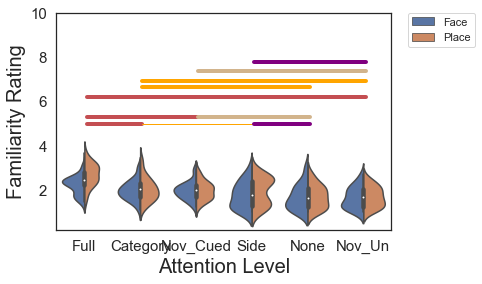

Experiment_2: Average Familiarity by Attention Level


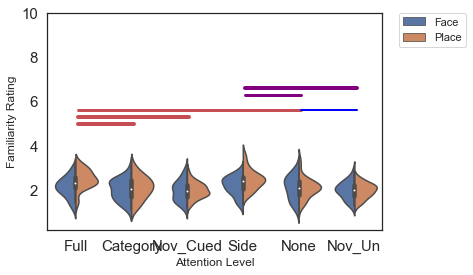

In [29]:
# needed: artificially add beginning of cascade and end of cascade pair to plotted_cats

# color list 
col = ['r','orange','tan','purple','blue','grey']

# cat list
cats = ['Full','Category','Nov_Cued','Side','None','Nov_Un']

# plot settings
sb.set_style("white")
plt.grid(False)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.xlabel('Attention Level',    fontsize = 20)
plt.ylabel('Familiarity Rating', fontsize = 20)

for d,label in zip([exp1, exp2],['Experiment_1', 'Experiment_2']):
    # for each experiment
    
    data = d.groupby(['Subject','Attention Level', 'Category'], as_index = False).mean()
    # group the data
    
    print(label + ': Average Familiarity by Attention Level')
    
    sb_plot = sb.violinplot(x='Attention Level', y='Familiarity Rating', 
                 data = data, hue='Category', split=True,
                 order=cats)
    
    sb_plot.set(ylim=(.2, 10))
    ax1 = sb_plot.axes
    # prepare plot
    
    save_string = label+'_violin_full.pdf'
    # plot save string
    
    ### SIGNIFICANCE FOR PLOTTING ###
    stat_dict = {}
    k = data.groupby(['Subject','Attention Level'],as_index=False).mean()

    for pair in list(itertools.combinations(cats, r=2)):
        t = stats.ttest_rel(k[k['Attention Level']==pair[0]]['Familiarity Rating'], 
                            k[k['Attention Level']==pair[1]]['Familiarity Rating'])

        # dictionary where every key is a pair of sig dif categories 
        if t[1]<.056:
            stat_dict[pair] = {'t': t.statistic, 'p': t.pvalue}
            
    ### ADD SIG BARS FOR POSITIVE RELATIONSHIPS TO PLOT ###
    plotted_cats = []
    
    line_counter = 0
    
    for idx,c in enumerate(cats):
    # for each category
    

        x = sig_bars(c, cats, stat_dict)
        # get first series of lines
        
        for idx,a in enumerate(x):
            
            if (a['categories'] not in plotted_cats) and (a!=np.nan) and (type(a['categories'])!=float):
            
                ax1.axhline(a['y']+line_counter, ls='-', xmin = a['x_min'], xmax = a['x_max'], linewidth = a['width'], 
                            color = col[cats.index(a['categories'][0])])

                plotted_cats.append(a['categories'])
                
#             if (a['next'] == 0) and (a['x_min'] !=0):
#                 line_counter += 1
            
            if a['next']!=0:
            # if next category also has pos, significant relationship
            
                fake_first = a['categories'][0]

                b = a
                
                while b['next']!= 0 :
                    
                    
                    b = sig_bars(b['next'], cats, stat_dict, adjust = (cats.index(c)-cats.index(b['next']))/len(cats))[0]
                    # get params for that bar, adjust height --> same level as first line

                    if (b['categories'] not in plotted_cats) and (b != np.nan) and (type(b['categories'])!=float):
                            
                        ax1.axhline(b['y']+line_counter, ls='-', xmin = b['x_min'], xmax = b['x_max'], 
                                    linewidth = b['width'], color = col[cats.index(b['categories'][0])])

                        plotted_cats.append(b['categories'])
                        
                        if type(plotted_cats[-1]) != float:
                            # print('fake')
                            l = plotted_cats[-1][0]
                            # print(fake_first+'_'+l)
                            # print('end fake')
                            
                        plotted_cats.append((fake_first,plotted_cats[-1][1]))
                            # plot line
                        
                    #if (b['next'] == 0) and (b['x_min'] !=0):              
            line_counter += .3
                        
            if type(plotted_cats[-1]) == str:
                fake_last = plotted_cats[-1][1]
                plotted_cats.append((fake_first, fake_last))
                
                
    
#     ### ADD SIG BARS FOR NEGATIVE RELATIONSHIPS TO PLOT ###
#     plotted_cats = []
    
#     line_counter = 0
    
#     for idx,c in enumerate(cats):
#     # for each category
    

#         x = sig_bars_neg(c, cats, stat_dict)
#         # get first series of lines
        
#         for idx,a in enumerate(x):
            
#             if (a['categories'] not in plotted_cats) and (a!=np.nan) and (type(a['categories'])!=float):
            
#                 ax1.axhline(a['y']+line_counter, ls='-', xmin = a['x_min'], xmax = a['x_max'], linewidth = a['width'], 
#                             color = col[cats.index(a['categories'][1])])

#                 plotted_cats.append(a['categories'])
                
# #             if (a['next'] == 0) and (a['x_min'] !=0):
# #                 line_counter += 1
            
#             if a['next']!=0:
#             # if next category also has pos, significant relationship
            
#                 fake_first = a['categories'][1]

#                 b = a
                
#                 while b['next']!= 0 :
                    
                    
#                     b = sig_bars_neg(b['next'], cats, stat_dict, adjust = (cats.index(c)-cats.index(b['next']))/len(cats))[0]
#                     # get params for that bar, adjust height --> same level as first line

#                     if (b['categories'] not in plotted_cats) and (b != np.nan) and (type(b['categories'])!=float):
                            
#                         ax1.axhline(b['y']+line_counter, ls='-', xmin = b['x_min'], xmax = b['x_max'], 
#                                     linewidth = b['width'], color = col[cats.index(b['categories'][1])])

#                         plotted_cats.append(b['categories'])
                        
# #                         if type(plotted_cats[-1]) != float:
# #                             print('fake')
# #                             l = plotted_cats[-1][1]
# #                             print(fake_first+'_'+l)
# #                             print('end fake')
                            
                    
#                         plotted_cats.append((fake_first,plotted_cats[-1][0]))
#                             # plot line
                            
#                     #if (b['next'] == 0) and (b['x_min'] !=0):              
#             line_counter += .3
                        
#             if len(plotted_cats)>0:
#                 if type(plotted_cats[-1]) == str:
#                     fake_last = plotted_cats[-1][0]

#                     plotted_cats.append((fake_first, fake_last))
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
        

In [30]:
[x for x in stat_dict.keys() if 'Full' in x]
stat_dict[('Full', 'Category')]


#[(data['Attention Level']==l)&(data['Category']=='Face')]['Familiarity Rating']

{'p': 0.00011194347011454554, 't': 4.46467110806929}

In [35]:
for exp in [exp1, exp2]:
    
    #for sub in exp['Subject'].unique():
        
    num_full = exp[exp['Attention Level']=='Full'    ].shape[0]  
    num_cat  = exp[exp['Attention Level']=='Category'].shape[0]  
    num_side = exp[exp['Attention Level']=='Side'    ].shape[0]  
    num_none = exp[exp['Attention Level']=='None'    ].shape[0]  

In [36]:
def ROC_prop(df, rate, attn, novel='matched'):
    '''
    input: subject df
           rating - Familiarity score (float between 1.0 and 4.0)
           attn - at time of encoding (string)

    output: proportion of images encoded at ATTENTION LEVEL
            given a score of RATE or higher, sorted by
            CATEGORY (if category == True)
    '''

    # proportions
    combined = float(df.loc[(df['Attention Level'] == attn) 
                  & (df['Familiarity Rating'] >= rate)].shape[0])/(df.loc[(df['Attention Level'] == attn) 
                  & (df['Familiarity Rating'] > 0)].shape[0])

    if novel == 'all':
        # all novel images for desired ratings in both categories
        denom_f = df.loc[(df['Attention Level'] == attn) & (df['Familiarity Rating'] > 0)].shape[0]
        denom_p = denom_f

    else:
        if novel   == 'matched':
            f_nov,p_nov = 'Face','Place'
        elif novel == 'opposite':
            p_nov,f_nov = 'Place','Face'

        denom_p = df.loc[(df['Attention Level'] == attn) & (df['Category'] == p_nov) & (df['Familiarity Rating'] > 0)].shape[0]
        denom_f = (df.loc[(df['Attention Level'] == attn) & (df['Category'] == f_nov) & (df['Familiarity Rating'] > 0)].shape[0])

    if df.loc[(df['Attention Level'] == attn) & (df['Category'] == 'Face')].shape[0] > 0:
        face = float(df.loc[(df['Attention Level'] == attn) & (df['Familiarity Rating'] >= rate) & (df['Category'] == 'Face')].shape[0])/denom_f
    else:
        face = np.nan

    if df.loc[(df['Attention Level'] == attn) & (df['Category'] == 'Place')].shape[0] > 0:
        house = float(df.loc[(df['Attention Level'] == attn) & (df['Familiarity Rating'] >= rate) & (df['Category'] == 'Place')].shape[0])/denom_p
    else:
        house = np.nan

    props = [combined, face, house]
    return(props)



def ROC_data(df, novel='matched'):
    '''
    input: subject df
    output: list of three ROC proportion sets (list of dicts): 1) all images, 2) faces, 3) places
    '''

    ratings = [4.0, 3.0, 2.0, 1.0]
    ROC, ROC_f, ROC_h = {},{},{}

    # for each attention level
    for attn in ['Nov_Cued','Nov_Un', 'None', 'Side', 'Full', 'Category']:
        for idx,roc in enumerate([ROC, ROC_f, ROC_h]):
            roc[attn] = [0]

            # for each possible number rating
            for rate in ratings:
                roc[attn].append(ROC_prop(df, rate, attn, novel=novel)[idx])

    return(ROC, ROC_f, ROC_h)



def ROC_plot(ROC_data, save_out=False, save='ROC.pdf'):
    '''
    input: ROC proportions (dictionary)
    output: displays plot of ROC curve
    '''

    fig, ax = plt.subplots()

    for attn,color in zip(['Category', 'Full'],['purple','blue']): # , 'None', 'Side'],['purple','blue','orange','red']):
        ax.plot(ROC_data['Nov_Cued'], ROC_data[attn], '-o', label=attn, color=color)
        
    for attn,color in zip(['None', 'Side'],['orange','red']): # , 'None', 'Side'],['purple','blue','orange','red']):
        ax.plot(ROC_data['Nov_Un'], ROC_data[attn], '-o', label=attn, color=color)

    plt.legend(loc='upper left');
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    if save_out == True:
        plt.savefig(save)
    plt.show()

def ROC_df(df):

    '''
    input:  full df
    output: list of subject df's with run-wise ROC data
    '''

    subject_list = []

    for sub in df['Subject'].unique():
        subject=[]

        for run in df['Run'].unique():
            subject.append(ROC_data(df[(df['Run']==run) & (df['Subject']==sub)]))
        subject_list.append(subject)

    return(subject_list)


def AUC(x_vals, y_vals):
    '''
    input:
    x_vals - x values for ROC curve, arranged left to right (list of floats)
    y_vals - y values for ROC curve, index matched to x_vals (list of floats)

    output:
    Area under the curve (AUC)
    '''

    AUC = 0

    for i,(x,y) in enumerate(zip(x_vals, y_vals)):
        if i>0:
            x_delt = x - x_vals[i-1]
            y_delt = y - y_vals[i-1]
            AUC += (y_vals[i-1] * x_delt) + (.5 * x_delt * y_delt)

    return(AUC)

### Raw Mean Familiarity Over Time - All Images

Experiment 1: Average Familiarity Over Time (Raw Data)


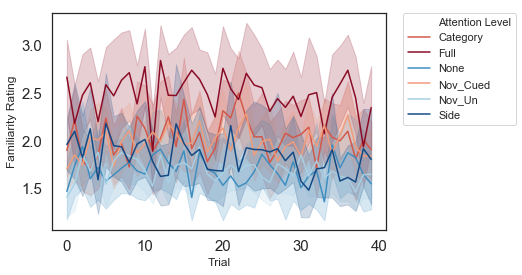

Experiment 2: Average Familiarity Over Time (Raw Data)


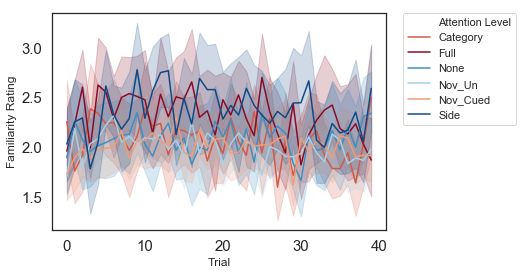

In [37]:
for data,label in zip([exp1, exp2],['Experiment 1','Experiment 2']): #plot_data.keys():
    
    print(label + ': Average Familiarity Over Time (Raw Data)')

    ax = sb.lineplot(x='Trial',y='Familiarity Rating', hue = 'Attention Level', 
                data = data.groupby(['Subject','Trial','Attention Level'], as_index=False).mean(), # ci=None,
                palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13]})
        
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    ax.set(ylim=(1.5, 3))

### Raw Mean Familiarity for Novel Images Over Time

Experiment 1: Average Familiarity for Novel Images Over Time (Raw Data)


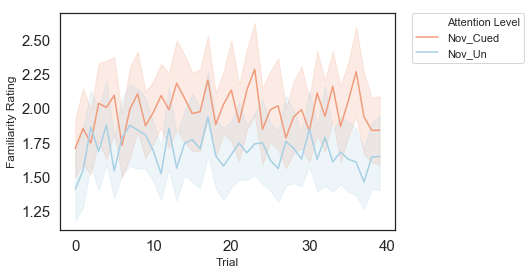

Experiment 2: Average Familiarity for Novel Images Over Time (Raw Data)


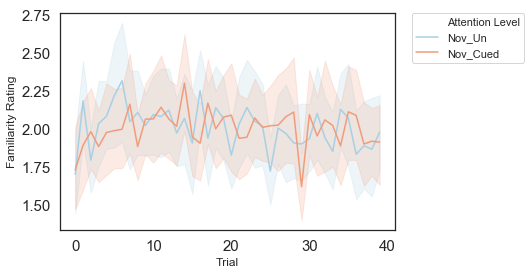

In [38]:
for data,label in zip([exp1, exp2],['Experiment 1','Experiment 2']): #plot_data.keys():
    
    print(label + ': Average Familiarity for Novel Images Over Time (Raw Data)')

    ax = sb.lineplot(x='Trial',y='Familiarity Rating', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Nov_Un','Nov_Cued'])].groupby(['Subject','Trial','Attention Level'], as_index=False).mean(), # ci=None,
                           palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13]})

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    ax.set(ylim=(1.5, 3))

### Sliding Window - Familiarity Over Time

ANOVA --> significant effect of attention level on familiarity both in the first and last window-sized chunks of "time," for both experiments.

*note : t-test breakdown for early vs late windows in later cells


exp1: Sliding Window - Familiarity Over Time


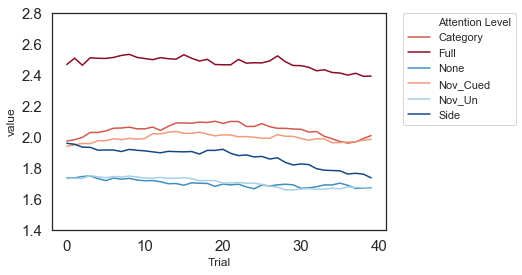


ANOVA on First Window --> Familiarity Rating ~ Attention Level

            Source  ddof1  ddof2       F         p-unc     p-GG-corr    np2  \
0  Attention Level      5    145  22.166  1.849372e-16  1.144160e-09  0.433   

     eps  sphericity  W-spher       p-spher  
0  0.524       False    0.065  3.808740e-10  


ANOVA on Last Window --> Familiarity Rating ~ Attention Level

            Source  ddof1  ddof2       F         p-unc     p-GG-corr    np2  \
0  Attention Level      5    145  36.283  5.667908e-24  1.648780e-16  0.556   

     eps  sphericity  W-spher   p-spher  
0  0.655       False    0.248  0.000551  


exp2: Sliding Window - Familiarity Over Time


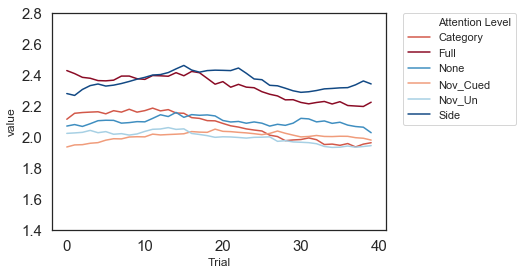


ANOVA on First Window --> Familiarity Rating ~ Attention Level

            Source  ddof1  ddof2      F         p-unc    np2    eps
0  Attention Level      5    145  9.482  7.673939e-08  0.246  0.832


ANOVA on Last Window --> Familiarity Rating ~ Attention Level

            Source  ddof1  ddof2     F         p-unc  p-GG-corr    np2    eps  \
0  Attention Level      5    145  9.73  4.954003e-08   0.000002  0.251  0.723   

   sphericity  W-spher   p-spher  
0       False    0.313  0.004687  




In [39]:
for key in plot_data.keys():
    
    print(key + ': Sliding Window - Familiarity Over Time')
    
    data = plot_data[key]
    
    # make a lineplot
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data.groupby(['Subject','Trial','Attention Level'], as_index=False).mean(),
                  palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13]},
                    ci = None) #, colors = ['green', 'blue', 'grey', 'red','orange','yellow'])
    
    # show plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylim=(1.4, 2.8))
    plt.show()
    
    # conduct anova on first and last window
    first_window = data[data['Trial']<10].groupby(['Attention Level','Subject'], as_index=False).mean()
    last_window  = data[data['Trial']>29].groupby(['Attention Level','Subject'], as_index=False).mean()
    anova = pingouin.rm_anova(dv='value', within='Attention Level', subject='Subject', data=first_window)
    anova_last = pingouin.rm_anova(dv='value', within='Attention Level', subject='Subject', data=last_window)

    # show anova result
    print()
    print('ANOVA on First Window --> Familiarity Rating ~ Attention Level')
    print()
    print(anova)
    print()
    print()
    print('ANOVA on Last Window --> Familiarity Rating ~ Attention Level')
    print()
    print(anova_last)
    print()
    print()

### Sliding Window - Novel Images

Exp 2: Novel Images that are not in the last-cued category have significantly higher familiarity ratings at the beginning of the memory block (first window) than they do at the end of the memory block (last window).

In [40]:
def timepoint_ttest(data, columns, related=True):
    '''
    input  : dataframe of timecourse-formatted behavioral data
             list with two strings, indicating which columns to compare
    output : dataframe with column containing moment-by-moment pvals
    '''
    
    data['timepoint_ttest']   = np.nan
    data['timepoint_t_truth'] = np.nan
    data['timepoint_t_value'] = np.nan
    
    for trial in data['Trial'].unique():

        a = list(data[(data['Trial']==trial) & (data['Attention Level']==columns[0])]['value'])
        b = list(data[(data['Trial']==trial) & (data['Attention Level']==columns[1])]['value'])

        if related == False:
            stat = scipy.stats.ttest_ind(a,b)
        else:
            stat = scipy.stats.ttest_rel(a,b)

        if stat.pvalue <.05:
            data.loc[(data['Attention Level'].isin(columns)) 
                   & (data['Trial']==trial),'timepoint_ttest'] = stat.pvalue
            data.loc[(data['Attention Level'].isin(columns)) 
                   & (data['Trial']==trial),'timepoint_tvalue'] = stat.statistic
            data.loc[(data['Attention Level'].isin(columns)) 
                   & (data['Trial']==trial),'timepoint_t_truth'] = True
        else:
            data.loc[(data['Attention Level'].isin(columns)) 
                   & (data['Trial']==trial),'timepoint_t_truth'] = False
            data.loc[(data['Attention Level'].isin(columns)) 
                   & (data['Trial']==trial),'timepoint_tvalue'] = stat.statistic
            data.loc[(data['Attention Level'].isin(columns)) 
                   & (data['Trial']==trial),'timepoint_ttest'] = stat.pvalue

        #print(scipy.stats.ttest_ind(a,b))
        
    return(data)

exp1: Sliding Window - Novel Images Only
[nan True]


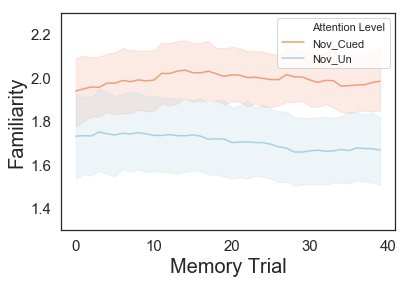

exp2: Sliding Window - Novel Images Only
[nan False]


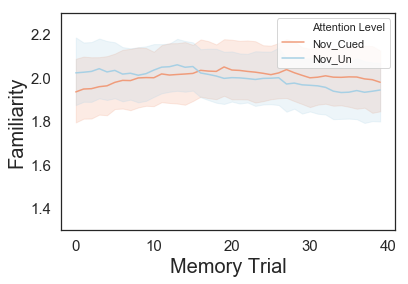

<Figure size 432x288 with 0 Axes>

In [41]:
sb.set_style("white")

for key,label in zip(plot_data.keys(),['Experiment_1','Experiment_2']):
    
    print(key + ': Sliding Window - Novel Images Only')
    
    data = plot_data[key]
    
    # plot data
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Nov_Un','Nov_Cued'])], # ci=None,
                palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13]})
    ax.set(ylim=(1.3, 2.3))
    
    plt.grid(False)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Attention Level',    fontsize = 20)
    plt.ylabel('Familiarity Rating', fontsize = 20)
    
    plt.xlabel('Memory Trial')
    plt.ylabel('Familiarity')
    
    
    
    # ttest at each timepoint ######################
    ttest_data = timepoint_ttest(data, ['Nov_Cued','Nov_Un'])
    print(ttest_data[ttest_data['Attention Level'].isin(['None','Nov_Un'])]['timepoint_t_truth'].unique())
    
    # add gret lines where pvalue is significant
    index = ttest_data[(ttest_data['Attention Level']=='None') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in index:
        plt.axvline(x, .1, .3, color='red')
    
    
    plt.show()    
    plt.savefig('Novel_tcourse_'+label+'.pdf')


        
#     # ttest first versus last window
#     for cat in ['Nov_Un', 'Nov_Cued']:
        
        
#         d = data[data['Attention Level']==cat]
        
#         # single first and last window
#         first_window = d[d['Trial']==0].groupby(['Attention Level','Subject'], as_index=False).mean()
#         first_window = d[d['Trial']==39].groupby(['Attention Level','Subject'], as_index=False).mean()
        
#         # first ten windows
# #         first_window = d[d['Trial']<(window_length*2)-1].groupby(['Attention Level','Subject'], as_index=False).mean()
# #         last_window  = d[d['Trial']>29].groupby(['Attention Level','Subject'], as_index=False).mean()
        
#         t = scipy.stats.ttest_ind(list(first_window['value']), list(last_window['value']))

#         print('t-test, first window versus last window: '+cat)
#         print(t)
#         print()
        
        

### Novel Image Difference Scores

In [42]:
list(trial_avs.loc[(trial_avs['Attention Level']=='Nov_Cued'),'value'])-list(trial_avs.loc[(trial_avs['Attention Level']=='Nov_Un'),'value'])

NameError: name 'trial_avs' is not defined

In [ ]:
for exp in plot_data.keys():
    
    trial_avs = plot_data[exp].groupby(['Trial','Attention Level','Subject'], as_index=False).mean()
    trial_avs['Nov_Diffs'] = np.nan
    
    for s in trial_avs['Subject'].unique():
        for t in trial_avs['Trial'].unique():

            first  = trial_avs[(trial_avs['Attention Level']=='Nov_Cued') 
                               & (trial_avs['Trial']==t)
                              & (trial_avs['Subject']==s)]['value'].item()
            second = trial_avs[(trial_avs['Attention Level']=='Nov_Un'  ) 
                               & (trial_avs['Trial']==t)
                              & (trial_avs['Subject']==s)]['value'].item()
            difference = first - second
            #print(difference)
            trial_avs.loc[(trial_avs['Trial']==t) & (trial_avs['Subject']==s),'Nov_Diffs'] = first - second

    ax = sb.lineplot(x='Trial', y='Nov_Diffs', data=trial_avs)
    ax.set(ylim=(-.1, .4))
        
    plt.grid(False)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Attention Level',    fontsize = 20)
    plt.ylabel('Familiarity Rating', fontsize = 20)
    
    plt.xlabel('Memory Trial')
    plt.ylabel('Familiarity Difference')
    plt.savefig('Novel_Diff_'+ exp +'.pdf')
    print(exp)
    plt.show()


In [ ]:
trial_avs[['Attention Level','Nov_Diffs']]['Nov_Diffs'].unique()

ax = sb.lineplot(x='Trial', y='Nov_Diffs', data=trial_avs)
ax.set(ylim=(-.1, .4))



In [ ]:
# data['mean_nov_diff'] = data[data['Attention Level']=='Nov_Un'
    
#     # plot data
#     ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
#                 data = data[data['Attention Level'].isin(['Nov_Un','Nov_Cued'])], # ci=None,
#                 palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
#                             "Side": palette[19], "None": palette[16], "Nov_Un":palette[13]})

### Sliding window with bars - add grey

In [ ]:
#data = plot_data['exp1']

In [ ]:
#ttest_data = timepoint_ttest(data, ['Nov_Cued','Nov_Un'])

In [ ]:
#ttest_data[ttest_data['Attention Level'].isin(['Nov_Un','Nov_Cued'])]['timepoint_t_truth'].unique()

In [ ]:
#sb.lineplot(x='Trial', y='timepoint_ttest', data=ttest_data[ttest_data['Attention Level']=='Nov_Cued'], ci=None)

In [43]:
ttest_data[ttest_data['Attention Level']=='Nov_Cued'].groupby(['Trial'],as_index=False)['timepoint_ttest'].mean()

,Trial,timepoint_ttest
0,0.0,0.238048
1,1.0,0.291506
2,2.0,0.248545
3,3.0,0.234357
4,4.0,0.320965
5,5.0,0.372066
6,6.0,0.631318
7,7.0,0.563562
8,8.0,0.814936
9,9.0,0.719678


Experiment 1: Sliding Window - Novel Images Only


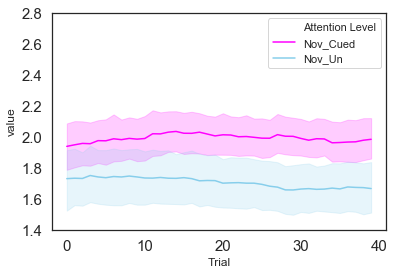

[True]


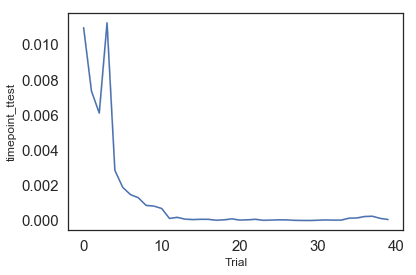

t-test, first window versus last window: Nov_Un
Ttest_relResult(statistic=1.072311225543634, pvalue=0.2924230422504016)


t-test, first window versus last window: Nov_Cued
Ttest_relResult(statistic=-0.7130830216781135, pvalue=0.4814935405610479)


Experiment 2: Sliding Window - Novel Images Only


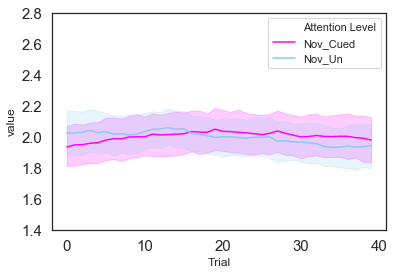

[False]


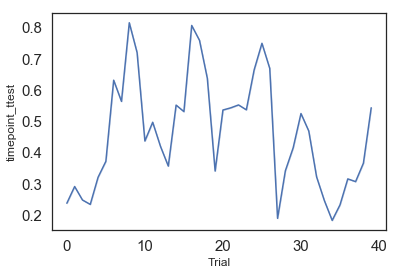

t-test, first window versus last window: Nov_Un
Ttest_relResult(statistic=1.2687477463130798, pvalue=0.2146208296963119)


t-test, first window versus last window: Nov_Cued
Ttest_relResult(statistic=-0.5693976457391752, pvalue=0.5734707138585988)




In [44]:
sb.set_style("white")


for key,label in zip(plot_data.keys(),['Experiment 1','Experiment 2']):
    
    print(label + ': Sliding Window - Novel Images Only')
    
    data = plot_data[key]
    
    # plot data
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Nov_Un','Nov_Cued'])], # ci=None,
                    palette = {"Full": "crimson", "Category": "deeppink", "Nov_Cued":"magenta", 
                           "Side": "blue", "None": "dodgerblue", "Nov_Un":"skyblue"})
    ax.set(ylim=(1.4, 2.8))
    plt.show()
    
    # ttest at each timepoint
    ttest_data = timepoint_ttest(data, ['Nov_Cued','Nov_Un'])
    print(ttest_data[ttest_data['Attention Level'].isin(['Nov_Un','Nov_Cued'])]['timepoint_t_truth'].unique())
    ax = sb.lineplot(x='Trial', y='timepoint_ttest', data=ttest_data[ttest_data['Attention Level']=='Nov_Cued'])
    # ax.set(ylim=(-.7,1))
    plt.show()
    
    ttest_data['abs_tval'] = ttest_data['timepoint_tvalue'].abs()
    
    
        # ttest first versus last window
    for cat in ['Nov_Un', 'Nov_Cued']:

        dat = data[data['Attention Level']==cat]
        
        first_window = dat[dat['Trial']<1].groupby(['Attention Level','Subject'], as_index=False).mean()
        last_window  = dat[dat['Trial']>38].groupby(['Attention Level','Subject'], as_index=False).mean()

        t = scipy.stats.ttest_rel(list(first_window['value']), list(last_window['value']))
    
        # t = scipy.stats.ttest_ind(list(first_window['value']), list(last_window['value']))

        print('t-test, first window versus last window: '+cat)
        print(t)
        print()
        print()
    
#     ax = sb.lineplot(x='Trial', y='timepoint_t_truth', data=ttest_data[ttest_data['Attention Level']=='Nov_Cued'])
#     ax.set(ylim=(-2, 6.5))
#     ax = sb.regplot(x='Trial', y='time', data=ttest_data[ttest_data['Attention Level']=='Nov_Cued'])
    
    
#     plt.grid(False)
#     plt.rc('xtick', labelsize=15)
#     plt.rc('ytick', labelsize=15)
#     plt.xlabel('Memory Trial',    fontsize = 20)
#     plt.ylabel('| t-statistic |', fontsize = 20)
    
#     plt.savefig('tcourse_t_regress_'+label+'.pdf')
#     plt.show()

In [45]:
# --> regression line on t stat over time

# --> familiarity for presented images (attn levels) as a function of their position on the presentation list
# --> for both exps (rec memory spc)
#     --> compare first to middle to end
#     --> primacy and recency
    
    
# # FUTURE
# #
# # temp clustering
# #  
# #
# #


### Sliding Window - Images in Uncued Category

In experiment 1, the images in the uncued category start with significiantly different familiarity ratings (first window), but byt hte end of the run, have familiarity ratings that are not significantly different (last window).

Experiment 2 is the opposite:  the images in the uncued category start not significiantly different from each other (first window), but by the end of the run, they have familiarity ratings that are significantly different (last window).

In experiment 1: "Side" images are significantly more familiar at the start of a run than at the end of a run.

In experiment 2: Novel imgaes from the last-uncued category are rated significantly more familiar in the first window than in the last window.

Experiment_1: Sliding Window - Uncued Category Images
[True]


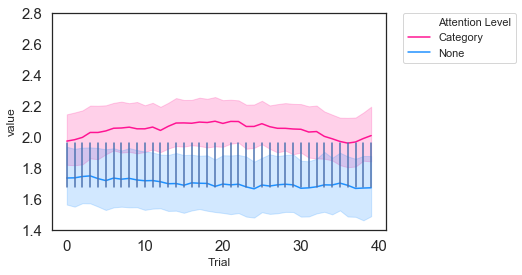



Experiment_2: Sliding Window - Uncued Category Images
[False True]


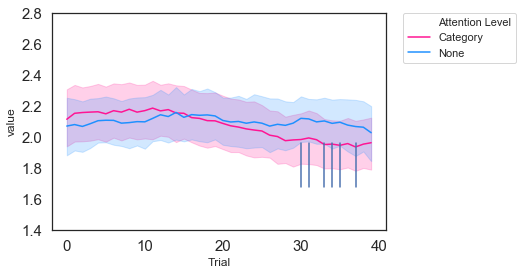

In [46]:
for key,label in zip(plot_data.keys(),['Experiment_1','Experiment_2']):
    
    print(label + ': Sliding Window - Uncued Category Images')
    
    data = plot_data[key]
    
    # plot data ##################################
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Category','None'])], # ci=None,
                    palette = {"Full": "crimson", "Category": "deeppink", "Nov_Cued":"magenta", 
                           "Side": "blue", "None": "dodgerblue", "Nov_Un":"skyblue"})
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylim=(1.4, 2.8))
    
    
    # ttest at each timepoint ######################
    ttest_data = timepoint_ttest(data, ['Category','None'])
    print(ttest_data[ttest_data['Attention Level'].isin(['Category','None'])]['timepoint_t_truth'].unique())
    
    # add gret lines where pvalue is significant
    index = ttest_data[(ttest_data['Attention Level']=='Category') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in index:
        plt.axvline(x, .2, .4)
        
    
    
    plt.savefig('Cat_None_'+label+'.pdf')
    plt.show()
    #################################################
    
    # ttest first versus last window
    
#     print('T-TESTS :')
#     print()
    
#     for cat in ['Nov_Un', 'Side', 'None']:

#         d = data[data['Attention Level']==cat]
        
#         # single first and last window
#         first_window = d[d['Trial']==0].groupby(['Attention Level','Subject'], as_index=False).mean()
#         first_window = d[d['Trial']==39].groupby(['Attention Level','Subject'], as_index=False).mean()
        
#         first_window = d[d['Trial']<(window_length*2)-1].groupby(['Attention Level','Subject'], as_index=False).mean()
#         last_window  = d[d['Trial']>29].groupby(['Attention Level','Subject'], as_index=False).mean()

#         t = scipy.stats.ttest_rel(list(first_window['value']), list(last_window['value']))
    
#         # t = scipy.stats.ttest_ind(list(first_window['value']), list(last_window['value']))

#         print('t-test, first window versus last window: '+cat)
#         print(t)
#         print()
#         print()


    print()
    print()

# Same w/ timepoint ttest

Experiment 1: Sliding Window - Uncued Category Images


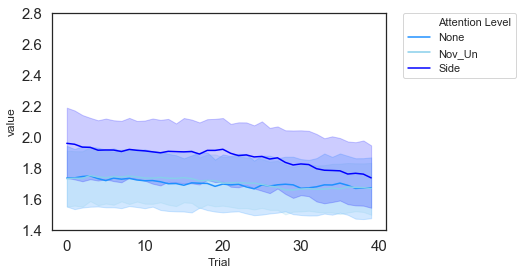

ANOVA - familiarity ~ attn levels - first sliding window:

            Source  ddof1  ddof2      F         p-unc    np2    eps
0  Attention Level      5    145  9.482  7.673939e-08  0.246  0.832


ANOVA - familiarity ~ attn levels - last sliding window:

            Source  ddof1  ddof2     F         p-unc  p-GG-corr    np2    eps  \
0  Attention Level      5    145  9.73  4.954003e-08   0.000002  0.251  0.723   

   sphericity  W-spher   p-spher  
0       False    0.313  0.004687  

T-TESTS :

t-test, first window versus last window: Nov_Un
Ttest_relResult(statistic=1.072311225543634, pvalue=0.2924230422504016)


t-test, first window versus last window: Side
Ttest_relResult(statistic=3.6273794372181722, pvalue=0.001088845534797051)


t-test, first window versus last window: None
Ttest_relResult(statistic=0.998115772811199, pvalue=0.32647919010779525)


Experiment 2: Sliding Window - Uncued Category Images


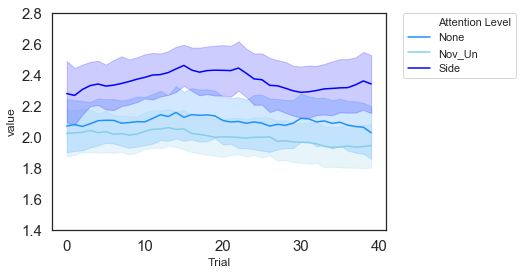

ANOVA - familiarity ~ attn levels - first sliding window:

            Source  ddof1  ddof2      F         p-unc    np2    eps
0  Attention Level      5    145  9.482  7.673939e-08  0.246  0.832


ANOVA - familiarity ~ attn levels - last sliding window:

            Source  ddof1  ddof2     F         p-unc  p-GG-corr    np2    eps  \
0  Attention Level      5    145  9.73  4.954003e-08   0.000002  0.251  0.723   

   sphericity  W-spher   p-spher  
0       False    0.313  0.004687  

T-TESTS :

t-test, first window versus last window: Nov_Un
Ttest_relResult(statistic=1.2687477463130798, pvalue=0.2146208296963119)


t-test, first window versus last window: Side
Ttest_relResult(statistic=-0.5857996002685433, pvalue=0.5625418673277772)


t-test, first window versus last window: None
Ttest_relResult(statistic=0.4875097663766799, pvalue=0.6295623254088263)




In [47]:
for key,label in zip(plot_data.keys(),['Experiment 1','Experiment 2']):
    
    print(label + ': Sliding Window - Uncued Category Images')
    
    data = plot_data[key]
    
    # plot data
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Side','None','Nov_Un'])], # ci=None,
                    palette = {"Full": "crimson", "Category": "deeppink", "Nov_Cued":"magenta", 
                           "Side": "blue", "None": "dodgerblue", "Nov_Un":"skyblue"})
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylim=(1.4, 2.8))
    plt.show()
    
    # stats test
    data = data[data['Attention Level'].isin(['Side','None','Nov_Un'])]
#     first_window = data[data['Trial']<1].groupby(['Attention Level','Subject'], as_index=False).mean()
#     last_window  = data[data['Trial']>38].groupby(['Attention Level','Subject'], as_index=False).mean()
#     anova = pingouin.rm_anova(dv='value', within='Attention Level', subject='Subject', data=first_window)
#     anova_last = pingouin.rm_anova(dv='value', within='Attention Level', subject='Subject', data=last_window)

    # show anova result
    print('ANOVA - familiarity ~ attn levels - first sliding window:')
    print()
    print(anova)
    print()
    print()
    print('ANOVA - familiarity ~ attn levels - last sliding window:')
    print()
    print(anova_last)
    
    print()
    print('T-TESTS :')
    print()
    
    # ttest first versus last window
    for cat in ['Nov_Un', 'Side', 'None']:

        dat = data[data['Attention Level']==cat]
        
        first_window = dat[dat['Trial']<1].groupby(['Attention Level','Subject'], as_index=False).mean()
        last_window  = dat[dat['Trial']>38].groupby(['Attention Level','Subject'], as_index=False).mean()

        t = scipy.stats.ttest_rel(list(first_window['value']), list(last_window['value']))
    
        # t = scipy.stats.ttest_ind(list(first_window['value']), list(last_window['value']))

        print('t-test, first window versus last window: '+cat)
        print(t)
        print()
        print()

### Sliding Window - Images in Cued Category

In Experiment 2, Fully attended and Category attended images have higher familiarity ratings at the beginning of the block (first window) than they do at the end (last window)

Experiment_1: Sliding Window - Same Category Images
[False True]
Full
Ttest_relResult(statistic=0.7246702297663677, pvalue=0.47446105088803125)

Category
Ttest_relResult(statistic=-0.42535739843296555, pvalue=0.6737161029266445)

Nov_Cued
Ttest_relResult(statistic=-0.7130830216781135, pvalue=0.4814935405610479)



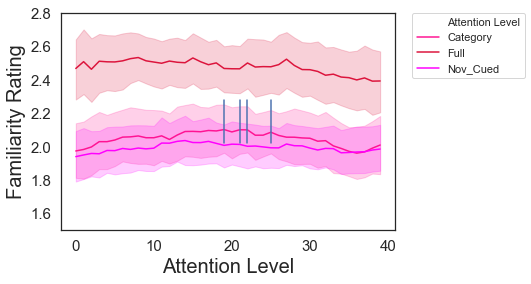

Experiment_2: Sliding Window - Same Category Images
[False True]
Full
Ttest_relResult(statistic=2.116484646613179, pvalue=0.043006089449216994)

Category
Ttest_relResult(statistic=1.6664020420033112, pvalue=0.10640004830067602)

Nov_Cued
Ttest_relResult(statistic=-0.5693976457391752, pvalue=0.5734707138585988)



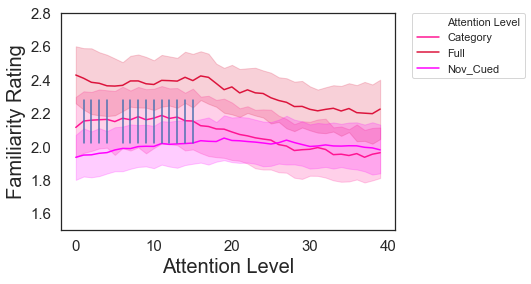

In [48]:
for key,label in zip(plot_data.keys(),['Experiment_1','Experiment_2']):
    
    print(label + ': Sliding Window - Same Category Images')
    
    data = plot_data[key]
    
    
    # plot ####################################
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Full', 'Nov_Cued', 'Category'])], # 'Category', # ci=None,
                    palette = {"Full": "crimson", "Category": "deeppink", "Nov_Cued":"magenta", 
                           "Side": "blue", "None": "dodgerblue", "Nov_Un":"skyblue"})
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylim=(1.5, 2.8))
    
    
    # ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Category','Nov_Cued'])
    print(ttest_data[ttest_data['Attention Level']=='Category']['timepoint_t_truth'].unique())
    
    
    # ttest first vs last ####################
    data = data[data['Attention Level'].isin(['Category','Full','Nov_Cued'])]
#     first_window = data[data['Trial']<1].groupby(['Attention Level','Subject'], as_index=False).mean()
#     last_window  = data[data['Trial']>38].groupby(['Attention Level','Subject'], as_index=False).mean()
#     anova = pingouin.rm_anova(dv='value', within='Attention Level', subject='Subject', data=first_window)
#     anova_last = pingouin.rm_anova(dv='value', within='Attention Level', subject='Subject', data=last_window)

    for cat in ['Full', 'Category', 'Nov_Cued']:

        dat = data[data['Attention Level']==cat]
        first_window = dat[dat['Trial']<1].groupby(['Attention Level','Subject'], as_index=False).mean()
        last_window  = dat[dat['Trial']>38].groupby(['Attention Level','Subject'], as_index=False).mean()
#         anova = pingouin.rm_anova(dv='value', within='Attention Level', subject='Subject', data=first_window)
#         anova_last = pingouin.rm_anova(dv='value', within='Attention Level
        
        t = scipy.stats.ttest_rel(list(first_window['value']), list(last_window['value']))
        print(cat)
        print(t)
        print()
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Category') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in index:
        plt.axvline(x, .4, .6)
        
    # plot settings & save ####################
    plt.grid(False)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Attention Level',    fontsize = 20)
    plt.ylabel('Familiarity Rating', fontsize = 20)
        
    plt.savefig(label+'_Full_Cat_NovCued.pdf')
    
    plt.show()
    
    
    
    

In [49]:
index

{1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0}

Experiment 1: Sliding Window - Same Side Images


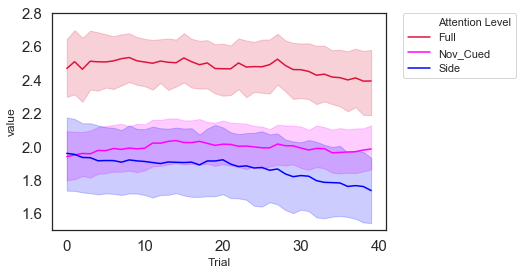

ANOVA - familiarity ~ attn levels : first sliding window:

            Source  ddof1  ddof2       F     p-unc    np2    eps
0  Attention Level      2     58  17.678  0.000001  0.379  0.934


ANOVA - familiarity ~ attn levels : last sliding window:

            Source  ddof1  ddof2       F         p-unc    np2    eps
0  Attention Level      2     58  34.396  1.411820e-10  0.543  0.871

T-TESTS : first window versus last window WITHING IMAGE TYPE 

t-test, first window versus last window: Full
Ttest_relResult(statistic=0.7246702297663677, pvalue=0.47446105088803125)


t-test, first window versus last window: Nov_Cued
Ttest_relResult(statistic=-0.7130830216781135, pvalue=0.4814935405610479)


t-test, first window versus last window: Side
Ttest_relResult(statistic=3.6273794372181722, pvalue=0.001088845534797051)


Experiment 2: Sliding Window - Same Side Images


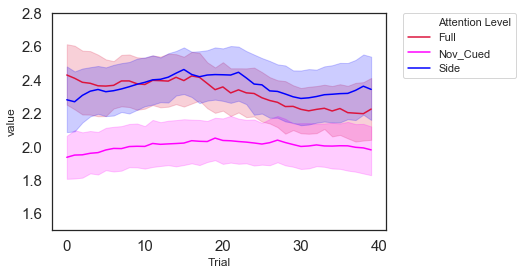

ANOVA - familiarity ~ attn levels : first sliding window:

            Source  ddof1  ddof2       F    p-unc    np2    eps
0  Attention Level      2     58  13.149  0.00002  0.312  0.853


ANOVA - familiarity ~ attn levels : last sliding window:

            Source  ddof1  ddof2      F     p-unc  p-GG-corr    np2    eps  \
0  Attention Level      2     58  9.394  0.000292   0.000889  0.245  0.798   

   sphericity  W-spher   p-spher  
0       False    0.747  0.016835  

T-TESTS : first window versus last window WITHING IMAGE TYPE 

t-test, first window versus last window: Full
Ttest_relResult(statistic=2.116484646613179, pvalue=0.043006089449216994)


t-test, first window versus last window: Nov_Cued
Ttest_relResult(statistic=-0.5693976457391752, pvalue=0.5734707138585988)


t-test, first window versus last window: Side
Ttest_relResult(statistic=-0.5857996002685433, pvalue=0.5625418673277772)




In [50]:
for key,label in zip(plot_data.keys(),['Experiment 1','Experiment 2']):
    
    print(label + ': Sliding Window - Same Side Images')
    
    data = plot_data[key]
    
    # plot
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Full', 'Side', 'Nov_Cued'])], # 'Category', # ci=None,
                    palette = {"Full": "crimson", "Category": "deeppink", "Nov_Cued":"magenta", 
                           "Side": "blue", "None": "dodgerblue", "Nov_Un":"skyblue"})
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylim=(1.5, 2.8))
    plt.show()
    
    
    # ANOVA yields Significantly different Fam Ratings in both first and last sliding windows, in both cases
    
        # stats test
    data = data[data['Attention Level'].isin(['Full','Side','Nov_Cued'])] #'Category',
    first_window = data[data['Trial']<1].groupby(['Attention Level','Subject'], as_index=False).mean()
    last_window  = data[data['Trial']>38].groupby(['Attention Level','Subject'], as_index=False).mean()
    anova = pingouin.rm_anova(dv='value', within='Attention Level', subject='Subject', data=first_window)
    anova_last = pingouin.rm_anova(dv='value', within='Attention Level', subject='Subject', data=last_window)

    # show anova result
    print('ANOVA - familiarity ~ attn levels : first sliding window:')
    print()
    print(anova)
    print()
    print()
    print('ANOVA - familiarity ~ attn levels : last sliding window:')
    print()
    print(anova_last)
    
    print()
    print('T-TESTS : first window versus last window WITHING IMAGE TYPE ')
    print()
    
    # ttest first versus last window
    for cat in ['Full','Nov_Cued','Side']:

        d = data[data['Attention Level']==cat]
        first_window = d[d['Trial']<1].groupby(['Attention Level','Subject'], as_index=False).mean()
        last_window  = d[d['Trial']>38].groupby(['Attention Level','Subject'], as_index=False).mean()

        t = scipy.stats.ttest_rel(list(first_window['value']), list(last_window['value']))

        print('t-test, first window versus last window: '+cat)
        print(t)
        print()
        print()


### Serial Position Analysis

In [58]:
exp1.head()

,Unnamed: 0.1,Subject,Trial Type,Run,Cued Composite,Uncued Composite,Cued Face,Cued Place,Uncued Face,Uncued Place,...,Attention Level,Cue Validity,Post Invalid Cue,Pre Invalid Cue,Attention Button,Rating History,Stimulus Onset,Stimulus End,Attention Probe,Trial
0,150,10,Presentation,3,00926960627Fa_sunapqwoeotxshkukbh.jpg,00076931230fa_sunaafewhewbxmjiurz.jpg,00926960627Fa.jpg,sunapqwoeotxshkukbh.jpg,00076931230fa.jpg,sunaafewhewbxmjiurz.jpg,...,NaN,1.0,NaN,NaN,1.0,NaN,1.538592e+09,1.538592e+09,x,NaN
1,151,10,Presentation,3,00725941201fa_sunaefgzwiramypjvtd.jpg,00828940307fa_sunahuynahneraqftyz.jpg,00725941201fa.jpg,sunaefgzwiramypjvtd.jpg,00828940307fa.jpg,sunahuynahneraqftyz.jpg,...,NaN,0.0,NaN,NaN,3.0,NaN,1.538592e+09,1.538592e+09,o,NaN
2,152,10,Presentation,3,00089931230fa_sunaagcpoejbuzyvddd.jpg,00730960620fa_sunaekgzpfilgjxpeyq.jpg,00089931230fa.jpg,sunaagcpoejbuzyvddd.jpg,00730960620fa.jpg,sunaekgzpfilgjxpeyq.jpg,...,NaN,1.0,NaN,NaN,1.0,NaN,1.538592e+09,1.538592e+09,x,NaN
3,153,10,Presentation,3,00978960627fa_sunbddbivbptlrlauhy.jpg,00265940128fb_sunabkmdplkdbvxriff.jpg,00978960627fa.jpg,sunbddbivbptlrlauhy.jpg,00265940128fb.jpg,sunabkmdplkdbvxriff.jpg,...,NaN,1.0,NaN,NaN,3.0,NaN,1.538592e+09,1.538592e+09,o,NaN
4,154,10,Presentation,3,00937960627fa_sunaqsolmfydodnakub.jpg,00788941205fa_sunagountlxpzkytsmp.jpg,00937960627fa.jpg,sunaqsolmfydodnakub.jpg,00788941205fa.jpg,sunagountlxpzkytsmp.jpg,...,NaN,1.0,NaN,NaN,1.0,NaN,1.538592e+09,1.538592e+09,x,NaN


In [59]:
exp2.head()

,Unnamed: 0.1,Subject,Trial Type,Run,Cued Composite,Uncued Composite,Cued Face,Cued Place,Uncued Face,Uncued Place,...,Cue Validity,Post Invalid Cue,Pre Invalid Cue,Attention Button,Rating History,Stimulus Onset,Stimulus End,Attention Probe,Trial,Last Cued
0,150,8.0,Presentation,3.0,00532960627fa_sunaccdtpgenvcbcbcf.jpg,00288940422fa_sunabppokiyglaxpcha.jpg,00532960627fa.jpg,sunaccdtpgenvcbcbcf.jpg,00288940422fa.jpg,sunabppokiyglaxpcha.jpg,...,1.0,NaN,NaN,1.0,NaN,1.551381e+09,1.551381e+09,x,0.0,NaN
1,151,8.0,Presentation,3.0,00787960620fa_sunagoufulkpsxrmklt.jpg,00857940307fa_sunaiwfobocrruqznsv.jpg,00787960620fa.jpg,sunagoufulkpsxrmklt.jpg,00857940307fa.jpg,sunaiwfobocrruqznsv.jpg,...,1.0,NaN,NaN,3.0,NaN,1.551381e+09,1.551381e+09,o,1.0,NaN
2,152,8.0,Presentation,3.0,00130931230fa_sunaamvxnvouicstkjb.jpg,00568940928fa_sunacsdhbbsybcyxnel.jpg,00130931230fa.jpg,sunaamvxnvouicstkjb.jpg,00568940928fa.jpg,sunacsdhbbsybcyxnel.jpg,...,1.0,NaN,NaN,1.0,NaN,1.551381e+09,1.551381e+09,x,2.0,NaN
3,153,8.0,Presentation,3.0,00967960627fa_sunbaejotfklekvpxcz.jpg,00929960627fa_sunaprnrbmgkomdbchr.jpg,00967960627fa.jpg,sunbaejotfklekvpxcz.jpg,00929960627fa.jpg,sunaprnrbmgkomdbchr.jpg,...,1.0,NaN,NaN,1.0,NaN,1.551381e+09,1.551381e+09,x,3.0,NaN
4,154,8.0,Presentation,3.0,00062931230fb_sunaaelotvjgibjtjhs.jpg,00663941121fa_sunadnjjzohjhbohlwq.jpg,00062931230fb.jpg,sunaaelotvjgibjtjhs.jpg,00663941121fa.jpg,sunadnjjzohjhbohlwq.jpg,...,1.0,NaN,NaN,3.0,NaN,1.551381e+09,1.551381e+09,o,4.0,NaN


In [60]:
def add_level(df, trials='block'):
    '''
    input: subject dataframe
    output: subject dataframe w/ Attention Level string for each Memory trial row
    '''
    for x in df.Run.unique():
        mask = df['Run']==x

        if trials == 'block':
            df[mask] = run_level(df[mask])
        elif trials == 'unique':
            df[mask] = run_level_unique(df[mask])

    return(df)


def run_level(df):
    '''
    input: df containing pres and mem from single run
    output: df with string in 'Attention Level' column in each Memory trial row
    '''
    #cued_cat = df[df['Trial Type']=='Presentation']['Cued Category'].tolist()[0]
    
    
    for index,row in df.iterrows():
        
        if row['Trial Type']=='Memory':
            mem_image = row['Memory Image']
            
            for cue in ['Cued ', 'Uncued ']:
                for cat in ['Face', 'Place']:
                    
                    if df.loc[df[cue+cat] == mem_image].shape[0]!=0:
                        
                        pres_trial = df.loc[df[cue+cat] == mem_image]['Trial'].item()
                        df['Pres Trial'][index] = pres_trial

#     mem_mask = df['Trial Type']=='Memory'
#     df.loc[mem_mask,'Pres Trial'] = df.loc[mem_mask,'Pres Trial'].fillna(np.nan)

    return(df)

# Add positions to mem images for SPC

In [61]:
exp1['Pres Trial'] = np.nan

In [62]:
total = []

for sub in [0]:
    
    print(sub)
    total.append(add_level(exp1[exp1['Subject']==sub]))
    
k = pd.concat(total)    

0


In [63]:
k['Pres Trial'].unique()

array([nan])

In [64]:
data = pd.concat(total)
data.to_csv('exp1_SPC')

In [65]:
# sb.lineplot(x='Pres Trial',y='Familiarity Rating', hue='Attention Level', data=data)

In [66]:
# data['Pres Trial']

In [67]:
exp1['Pres Trial'] = np.nan

In [68]:
exp1

,Unnamed: 0.1,Subject,Trial Type,Run,Cued Composite,Uncued Composite,Cued Face,Cued Place,Uncued Face,Uncued Place,...,Cue Validity,Post Invalid Cue,Pre Invalid Cue,Attention Button,Rating History,Stimulus Onset,Stimulus End,Attention Probe,Trial,Pres Trial
0,150,10,Presentation,3,00926960627Fa_sunapqwoeotxshkukbh.jpg,00076931230fa_sunaafewhewbxmjiurz.jpg,00926960627Fa.jpg,sunapqwoeotxshkukbh.jpg,00076931230fa.jpg,sunaafewhewbxmjiurz.jpg,...,1.0,NaN,NaN,1.0,NaN,1.538592e+09,1.538592e+09,x,NaN,NaN
1,151,10,Presentation,3,00725941201fa_sunaefgzwiramypjvtd.jpg,00828940307fa_sunahuynahneraqftyz.jpg,00725941201fa.jpg,sunaefgzwiramypjvtd.jpg,00828940307fa.jpg,sunahuynahneraqftyz.jpg,...,0.0,NaN,NaN,3.0,NaN,1.538592e+09,1.538592e+09,o,NaN,NaN
2,152,10,Presentation,3,00089931230fa_sunaagcpoejbuzyvddd.jpg,00730960620fa_sunaekgzpfilgjxpeyq.jpg,00089931230fa.jpg,sunaagcpoejbuzyvddd.jpg,00730960620fa.jpg,sunaekgzpfilgjxpeyq.jpg,...,1.0,NaN,NaN,1.0,NaN,1.538592e+09,1.538592e+09,x,NaN,NaN
3,153,10,Presentation,3,00978960627fa_sunbddbivbptlrlauhy.jpg,00265940128fb_sunabkmdplkdbvxriff.jpg,00978960627fa.jpg,sunbddbivbptlrlauhy.jpg,00265940128fb.jpg,sunabkmdplkdbvxriff.jpg,...,1.0,NaN,NaN,3.0,NaN,1.538592e+09,1.538592e+09,o,NaN,NaN
4,154,10,Presentation,3,00937960627fa_sunaqsolmfydodnakub.jpg,00788941205fa_sunagountlxpzkytsmp.jpg,00937960627fa.jpg,sunaqsolmfydodnakub.jpg,00788941205fa.jpg,sunagountlxpzkytsmp.jpg,...,1.0,NaN,NaN,1.0,NaN,1.538592e+09,1.538592e+09,x,NaN,NaN
5,155,10,Presentation,3,00650941031fa_sunadikxpvqeabxrvvc.jpg,00810941205fa_sunahctntqrunhdxhtb.jpg,00650941031fa.jpg,sunadikxpvqeabxrvvc.jpg,00810941205fa.jpg,sunahctntqrunhdxhtb.jpg,...,1.0,NaN,NaN,1.0,NaN,1.538592e+09,1.538592e+09,x,NaN,NaN
6,156,10,Presentation,3,00796941205fa_sunaguchqqnrtodtezq.jpg,00751960620fa_sunaezuszgtxnmsxdbk.jpg,00796941205fa.jpg,sunaguchqqnrtodtezq.jpg,00751960620fa.jpg,sunaezuszgtxnmsxdbk.jpg,...,1.0,NaN,NaN,1.0,NaN,1.538592e+09,1.538592e+09,x,NaN,NaN
7,157,10,Presentation,3,00700941121fa_sunadsgmtznewzyasnk.jpg,00061931230fb_sunaaekxzjzrfgtkwjf.jpg,00700941121fa.jpg,sunadsgmtznewzyasnk.jpg,00061931230fb.jpg,sunaaekxzjzrfgtkwjf.jpg,...,1.0,NaN,NaN,3.0,NaN,1.538592e+09,1.538592e+09,o,NaN,NaN
8,158,10,Presentation,3,00950960627fa_sunasrjlmglmjzbmqxb.jpg,00809960620fa_sunahbvlpavurqoxdeq.jpg,00950960627fa.jpg,sunasrjlmglmjzbmqxb.jpg,00809960620fa.jpg,sunahbvlpavurqoxdeq.jpg,...,1.0,NaN,NaN,1.0,NaN,1.538592e+09,1.538592e+09,x,NaN,NaN
9,159,10,Presentation,3,00963960627fa_sunayaepykrqvenaqqy.jpg,00939960627fa_sunarceibpcyacbmfga.jpg,00963960627fa.jpg,sunayaepykrqvenaqqy.jpg,00939960627fa.jpg,sunarceibpcyacbmfga.jpg,...,1.0,NaN,NaN,3.0,NaN,1.538592e+09,1.538593e+09,o,NaN,NaN


# Graveyard

In [166]:
    
#     # conduct anova on first and last window
#     first_window = data[data['Trial']<10].groupby(['Attention Level','Subject'], as_index=False).mean()
#     last_window  = data[data['Trial']>29].groupby(['Attention Level','Subject'], as_index=False).mean()
#     anova = pingouin.rm_anova(dv='value', within='Attention Level', subject='Subject', data=first_window)
#     anova_last = pingouin.rm_anova(dv='value', within='Attention Level', subject='Subject', data=last_window)
    
#     # show anova result
#     print(anova)
#     print(anova_last)

In [267]:
# palette

# palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
#            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13]}